### Optimized Modified ResNet Architecture.

Need to install MLflow library if not already installed and then import all the dependencies.

In [ ]:
!pip install mlflow

In [ ]:
from tqdm import tqdm
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import torch.nn.utils.prune as prune
import mlflow

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data loading and preprocessing

In [ ]:

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Function to count the trainable parameters in the model.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Defining the Resnet Architecture:
First, we define a simplified basic block for the Resnet Architecture and define the simplified ResNet architecture using an initial convolutional layer, batch normalization and ReLU activation with 3 layers and varying number of blocks and strides and define the adaptive pooling layer. Then we have a make layer function to create layers with specified number of blocks and output channels.

In [ ]:
class SimplifiedBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SimplifiedBasicBlock, self).__init__()
       # Define the first convolutional layer with batch normalization and ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Define the second convolutional layer with batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)


        # Initialize the shortcut connection as an empty sequential container
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    #Define the forward pass
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add the shortcut connection
        out = self.relu(out)
        return out


# Define the simplified ResNet architecture
class SimplifiedResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(SimplifiedResNet, self).__init__()
        self.in_channels = 64

        # Define the initial convolutional layer, batch normalization and ReLU activation
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Define the three layers with varying number of blocks and strides
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)

        # Define the adaptive average pooling layer, dropout and final fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_classes)

    
    # Function to create layers with specified number of blocks and output channels
    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(SimplifiedBasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    
    # Define the forward pass of the simplified ResNet architecture
    def forward(self, x):
      # Apply the initial layers, followed by the three main layers
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # Apply the adaptive average pooling
        out = self.avgpool(out)

        # Flatten the tensor before passing it through dropout and fully connected layer
        out = out.view(out.size(0), -1)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Function to create a simplified ResNet instance with specified number of blocks
def simplified_resnet():
    return SimplifiedResNet(num_blocks=[4, 4, 3])

# Create a simplified ResNet model instance and move it to the specified device (e.g., GPU if available)
model = simplified_resnet().to(device)

# Print a summary of the model architecture and its input/output shapes
summary(model, (3,32,32))

# Calculate and print the number of trainable parameters in the model
print(f"Trainable parameters: {count_parameters(model)}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
SimplifiedBasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 

### Training and Validation:
Defining the optimizer, scheduler and training and validation functions for the model. 

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)

# Define the training function for the model.
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
# Iterate over the training data
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients of the optimizer
        optimizer.zero_grad()
        # Forward pass through the model
        outputs = model(inputs)
         # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass to compute gradients
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Update running loss and correct predictions count
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
 # Calculate the average loss and accuracy for the epoch
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


# Define the validation function for the model
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    # Iterate over the validation data without updating gradients
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass through the model
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Update running loss and correct predictions count
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
# Calculate the average loss and accuracy for the epoch
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

Train and Validate the model for a specified number of epochs (200 in this case) using the previously defined train() and validate() functions. MLflow is used to log the training and validation process, and to track the performance of your model over time.

In [ ]:
# Start the experiment
best_test_acc = 0.0
with mlflow.start_run() as run:
    num_epochs = 200
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_acc = validate(model, testloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        scheduler.step()

        print(f"Epoch: {epoch + 1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        
        if test_acc > best_test_acc:
          best_test_acc = test_acc
          torch.save(model.state_dict(), 'best_model.pt')

        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test_acc", test_acc, step=epoch)

100%|██████████| 500/500 [00:12<00:00, 41.17it/s]


Epoch: 1/200 | Train Loss: 1.7791 | Train Acc: 34.4440 | Test Loss: 1.6590 | Test Acc: 42.6600


100%|██████████| 500/500 [00:11<00:00, 41.80it/s]


Epoch: 2/200 | Train Loss: 1.2463 | Train Acc: 54.7180 | Test Loss: 1.5177 | Test Acc: 52.4400


100%|██████████| 500/500 [00:12<00:00, 41.60it/s]


Epoch: 3/200 | Train Loss: 0.9902 | Train Acc: 64.9880 | Test Loss: 0.9908 | Test Acc: 66.5300


100%|██████████| 500/500 [00:12<00:00, 40.80it/s]


Epoch: 4/200 | Train Loss: 0.7955 | Train Acc: 72.5400 | Test Loss: 0.8310 | Test Acc: 72.3600


100%|██████████| 500/500 [00:12<00:00, 41.26it/s]


Epoch: 5/200 | Train Loss: 0.6909 | Train Acc: 76.2680 | Test Loss: 1.1093 | Test Acc: 65.9400


100%|██████████| 500/500 [00:12<00:00, 40.56it/s]


Epoch: 6/200 | Train Loss: 0.6280 | Train Acc: 78.4420 | Test Loss: 0.7268 | Test Acc: 75.6800


100%|██████████| 500/500 [00:12<00:00, 41.20it/s]


Epoch: 7/200 | Train Loss: 0.5818 | Train Acc: 80.3100 | Test Loss: 0.7149 | Test Acc: 75.8200


100%|██████████| 500/500 [00:12<00:00, 39.15it/s]


Epoch: 8/200 | Train Loss: 0.5579 | Train Acc: 81.0520 | Test Loss: 0.7505 | Test Acc: 75.6300


100%|██████████| 500/500 [00:12<00:00, 40.30it/s]


Epoch: 9/200 | Train Loss: 0.5338 | Train Acc: 81.8000 | Test Loss: 0.6033 | Test Acc: 79.6900


100%|██████████| 500/500 [00:12<00:00, 38.77it/s]


Epoch: 10/200 | Train Loss: 0.5122 | Train Acc: 82.7480 | Test Loss: 1.3486 | Test Acc: 64.4100


100%|██████████| 500/500 [00:12<00:00, 38.56it/s]


Epoch: 11/200 | Train Loss: 0.4976 | Train Acc: 83.2400 | Test Loss: 0.7409 | Test Acc: 76.1200


100%|██████████| 500/500 [00:12<00:00, 39.00it/s]


Epoch: 12/200 | Train Loss: 0.4814 | Train Acc: 83.7940 | Test Loss: 0.6656 | Test Acc: 79.0000


100%|██████████| 500/500 [00:13<00:00, 38.28it/s]


Epoch: 13/200 | Train Loss: 0.4728 | Train Acc: 83.9640 | Test Loss: 0.7047 | Test Acc: 77.5000


100%|██████████| 500/500 [00:12<00:00, 38.50it/s]


Epoch: 14/200 | Train Loss: 0.4624 | Train Acc: 84.3780 | Test Loss: 0.6336 | Test Acc: 78.1900


100%|██████████| 500/500 [00:12<00:00, 39.03it/s]


Epoch: 15/200 | Train Loss: 0.4536 | Train Acc: 84.5360 | Test Loss: 0.7184 | Test Acc: 77.4000


100%|██████████| 500/500 [00:12<00:00, 39.13it/s]


Epoch: 16/200 | Train Loss: 0.4505 | Train Acc: 84.7440 | Test Loss: 0.5691 | Test Acc: 81.6700


100%|██████████| 500/500 [00:12<00:00, 38.59it/s]


Epoch: 17/200 | Train Loss: 0.4375 | Train Acc: 85.1800 | Test Loss: 0.6122 | Test Acc: 79.8200


100%|██████████| 500/500 [00:13<00:00, 38.18it/s]


Epoch: 18/200 | Train Loss: 0.4378 | Train Acc: 85.1840 | Test Loss: 0.5391 | Test Acc: 81.5700


100%|██████████| 500/500 [00:13<00:00, 37.61it/s]


Epoch: 19/200 | Train Loss: 0.4239 | Train Acc: 85.7320 | Test Loss: 0.5602 | Test Acc: 81.6900


100%|██████████| 500/500 [00:12<00:00, 38.54it/s]


Epoch: 20/200 | Train Loss: 0.4246 | Train Acc: 85.7280 | Test Loss: 0.5360 | Test Acc: 81.7800


100%|██████████| 500/500 [00:12<00:00, 39.06it/s]


Epoch: 21/200 | Train Loss: 0.4240 | Train Acc: 85.7860 | Test Loss: 0.5556 | Test Acc: 82.1000


100%|██████████| 500/500 [00:12<00:00, 38.63it/s]


Epoch: 22/200 | Train Loss: 0.4081 | Train Acc: 86.2080 | Test Loss: 0.5218 | Test Acc: 82.4600


100%|██████████| 500/500 [00:12<00:00, 38.74it/s]


Epoch: 23/200 | Train Loss: 0.4113 | Train Acc: 86.1920 | Test Loss: 0.5393 | Test Acc: 81.8700


100%|██████████| 500/500 [00:12<00:00, 39.16it/s]


Epoch: 24/200 | Train Loss: 0.4018 | Train Acc: 86.3760 | Test Loss: 0.4481 | Test Acc: 85.2100


100%|██████████| 500/500 [00:12<00:00, 38.56it/s]


Epoch: 25/200 | Train Loss: 0.4062 | Train Acc: 86.3020 | Test Loss: 0.4707 | Test Acc: 84.3100


100%|██████████| 500/500 [00:12<00:00, 38.71it/s]


Epoch: 26/200 | Train Loss: 0.4004 | Train Acc: 86.5240 | Test Loss: 0.5354 | Test Acc: 82.4200


100%|██████████| 500/500 [00:12<00:00, 38.47it/s]


Epoch: 27/200 | Train Loss: 0.3959 | Train Acc: 86.5940 | Test Loss: 0.6564 | Test Acc: 79.7800


100%|██████████| 500/500 [00:12<00:00, 38.91it/s]


Epoch: 28/200 | Train Loss: 0.3932 | Train Acc: 86.7720 | Test Loss: 0.7670 | Test Acc: 76.5100


100%|██████████| 500/500 [00:13<00:00, 38.35it/s]


Epoch: 29/200 | Train Loss: 0.3932 | Train Acc: 86.7920 | Test Loss: 0.6298 | Test Acc: 80.5200


100%|██████████| 500/500 [00:12<00:00, 38.71it/s]


Epoch: 30/200 | Train Loss: 0.3927 | Train Acc: 86.7860 | Test Loss: 0.5112 | Test Acc: 82.9000


100%|██████████| 500/500 [00:12<00:00, 38.91it/s]


Epoch: 31/200 | Train Loss: 0.3905 | Train Acc: 86.9100 | Test Loss: 0.5463 | Test Acc: 81.7000


100%|██████████| 500/500 [00:13<00:00, 38.44it/s]


Epoch: 32/200 | Train Loss: 0.3906 | Train Acc: 86.8740 | Test Loss: 0.5362 | Test Acc: 82.3400


100%|██████████| 500/500 [00:13<00:00, 38.45it/s]


Epoch: 33/200 | Train Loss: 0.3857 | Train Acc: 87.0340 | Test Loss: 0.5778 | Test Acc: 82.0500


100%|██████████| 500/500 [00:13<00:00, 38.37it/s]


Epoch: 34/200 | Train Loss: 0.3860 | Train Acc: 86.9200 | Test Loss: 0.5802 | Test Acc: 80.9000


100%|██████████| 500/500 [00:13<00:00, 38.11it/s]


Epoch: 35/200 | Train Loss: 0.3845 | Train Acc: 86.9860 | Test Loss: 0.5698 | Test Acc: 81.8500


100%|██████████| 500/500 [00:13<00:00, 38.28it/s]


Epoch: 36/200 | Train Loss: 0.3830 | Train Acc: 87.1780 | Test Loss: 0.6319 | Test Acc: 79.1500


100%|██████████| 500/500 [00:12<00:00, 39.27it/s]


Epoch: 37/200 | Train Loss: 0.3801 | Train Acc: 87.3400 | Test Loss: 0.5230 | Test Acc: 82.4300


100%|██████████| 500/500 [00:12<00:00, 39.85it/s]


Epoch: 38/200 | Train Loss: 0.3768 | Train Acc: 87.3840 | Test Loss: 0.6733 | Test Acc: 78.1500


100%|██████████| 500/500 [00:12<00:00, 40.73it/s]


Epoch: 39/200 | Train Loss: 0.3785 | Train Acc: 87.1800 | Test Loss: 0.5674 | Test Acc: 81.6400


100%|██████████| 500/500 [00:12<00:00, 41.09it/s]


Epoch: 40/200 | Train Loss: 0.3781 | Train Acc: 87.3380 | Test Loss: 0.5607 | Test Acc: 82.0200


100%|██████████| 500/500 [00:12<00:00, 41.12it/s]


Epoch: 41/200 | Train Loss: 0.3825 | Train Acc: 87.1100 | Test Loss: 0.6058 | Test Acc: 80.3500


100%|██████████| 500/500 [00:12<00:00, 40.83it/s]


Epoch: 42/200 | Train Loss: 0.3813 | Train Acc: 87.2300 | Test Loss: 0.4602 | Test Acc: 85.2100


100%|██████████| 500/500 [00:12<00:00, 41.07it/s]


Epoch: 43/200 | Train Loss: 0.3778 | Train Acc: 87.3760 | Test Loss: 0.6035 | Test Acc: 81.0900


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 44/200 | Train Loss: 0.3681 | Train Acc: 87.6600 | Test Loss: 0.4977 | Test Acc: 83.7900


100%|██████████| 500/500 [00:12<00:00, 41.15it/s]


Epoch: 45/200 | Train Loss: 0.3736 | Train Acc: 87.4800 | Test Loss: 0.4769 | Test Acc: 83.8400


100%|██████████| 500/500 [00:12<00:00, 41.14it/s]


Epoch: 46/200 | Train Loss: 0.3759 | Train Acc: 87.2560 | Test Loss: 0.7341 | Test Acc: 76.8900


100%|██████████| 500/500 [00:12<00:00, 41.20it/s]


Epoch: 47/200 | Train Loss: 0.3756 | Train Acc: 87.3360 | Test Loss: 0.6809 | Test Acc: 77.9300


100%|██████████| 500/500 [00:12<00:00, 41.23it/s]


Epoch: 48/200 | Train Loss: 0.3723 | Train Acc: 87.3380 | Test Loss: 0.5320 | Test Acc: 82.3600


100%|██████████| 500/500 [00:12<00:00, 41.11it/s]


Epoch: 49/200 | Train Loss: 0.3703 | Train Acc: 87.5480 | Test Loss: 0.6482 | Test Acc: 80.7200


100%|██████████| 500/500 [00:12<00:00, 40.76it/s]


Epoch: 50/200 | Train Loss: 0.3690 | Train Acc: 87.6660 | Test Loss: 0.4863 | Test Acc: 83.9500


100%|██████████| 500/500 [00:12<00:00, 41.45it/s]


Epoch: 51/200 | Train Loss: 0.2028 | Train Acc: 93.2520 | Test Loss: 0.2191 | Test Acc: 92.1500


100%|██████████| 500/500 [00:12<00:00, 41.61it/s]


Epoch: 52/200 | Train Loss: 0.1503 | Train Acc: 95.0840 | Test Loss: 0.2021 | Test Acc: 93.0500


100%|██████████| 500/500 [00:12<00:00, 40.63it/s]


Epoch: 53/200 | Train Loss: 0.1274 | Train Acc: 95.8040 | Test Loss: 0.1944 | Test Acc: 93.5600


100%|██████████| 500/500 [00:12<00:00, 40.98it/s]


Epoch: 54/200 | Train Loss: 0.1131 | Train Acc: 96.2540 | Test Loss: 0.2030 | Test Acc: 93.3000


100%|██████████| 500/500 [00:12<00:00, 40.44it/s]


Epoch: 55/200 | Train Loss: 0.1030 | Train Acc: 96.5980 | Test Loss: 0.2022 | Test Acc: 93.6200


100%|██████████| 500/500 [00:12<00:00, 40.98it/s]


Epoch: 56/200 | Train Loss: 0.0896 | Train Acc: 97.1260 | Test Loss: 0.2040 | Test Acc: 93.3600


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 57/200 | Train Loss: 0.0808 | Train Acc: 97.3440 | Test Loss: 0.2010 | Test Acc: 93.7700


100%|██████████| 500/500 [00:12<00:00, 40.45it/s]


Epoch: 58/200 | Train Loss: 0.0778 | Train Acc: 97.4700 | Test Loss: 0.2010 | Test Acc: 93.8800


100%|██████████| 500/500 [00:12<00:00, 40.93it/s]


Epoch: 59/200 | Train Loss: 0.0681 | Train Acc: 97.8960 | Test Loss: 0.2046 | Test Acc: 93.7500


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 60/200 | Train Loss: 0.0626 | Train Acc: 97.9920 | Test Loss: 0.2136 | Test Acc: 93.6700


100%|██████████| 500/500 [00:12<00:00, 41.22it/s]


Epoch: 61/200 | Train Loss: 0.0606 | Train Acc: 98.0080 | Test Loss: 0.2089 | Test Acc: 93.6700


100%|██████████| 500/500 [00:12<00:00, 40.66it/s]


Epoch: 62/200 | Train Loss: 0.0584 | Train Acc: 98.1320 | Test Loss: 0.2272 | Test Acc: 93.1500


100%|██████████| 500/500 [00:12<00:00, 39.87it/s]


Epoch: 63/200 | Train Loss: 0.0561 | Train Acc: 98.1960 | Test Loss: 0.2085 | Test Acc: 93.7700


100%|██████████| 500/500 [00:12<00:00, 40.07it/s]


Epoch: 64/200 | Train Loss: 0.0505 | Train Acc: 98.3660 | Test Loss: 0.2280 | Test Acc: 93.3700


100%|██████████| 500/500 [00:12<00:00, 41.45it/s]


Epoch: 65/200 | Train Loss: 0.0522 | Train Acc: 98.3180 | Test Loss: 0.2360 | Test Acc: 93.2900


100%|██████████| 500/500 [00:12<00:00, 40.29it/s]


Epoch: 66/200 | Train Loss: 0.0523 | Train Acc: 98.3960 | Test Loss: 0.2200 | Test Acc: 93.5900


100%|██████████| 500/500 [00:12<00:00, 40.53it/s]


Epoch: 67/200 | Train Loss: 0.0510 | Train Acc: 98.3980 | Test Loss: 0.2466 | Test Acc: 93.2300


100%|██████████| 500/500 [00:12<00:00, 40.52it/s]


Epoch: 68/200 | Train Loss: 0.0480 | Train Acc: 98.5100 | Test Loss: 0.2667 | Test Acc: 92.7700


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 69/200 | Train Loss: 0.0557 | Train Acc: 98.2520 | Test Loss: 0.2397 | Test Acc: 93.1200


100%|██████████| 500/500 [00:12<00:00, 40.91it/s]


Epoch: 70/200 | Train Loss: 0.0515 | Train Acc: 98.3640 | Test Loss: 0.2589 | Test Acc: 92.7700


100%|██████████| 500/500 [00:12<00:00, 40.93it/s]


Epoch: 71/200 | Train Loss: 0.0504 | Train Acc: 98.4180 | Test Loss: 0.2224 | Test Acc: 93.6300


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 72/200 | Train Loss: 0.0561 | Train Acc: 98.1920 | Test Loss: 0.2358 | Test Acc: 93.1600


100%|██████████| 500/500 [00:12<00:00, 41.32it/s]


Epoch: 73/200 | Train Loss: 0.0557 | Train Acc: 98.1880 | Test Loss: 0.2455 | Test Acc: 93.0000


100%|██████████| 500/500 [00:12<00:00, 40.42it/s]


Epoch: 74/200 | Train Loss: 0.0529 | Train Acc: 98.3200 | Test Loss: 0.2837 | Test Acc: 92.1000


100%|██████████| 500/500 [00:12<00:00, 41.18it/s]


Epoch: 75/200 | Train Loss: 0.0534 | Train Acc: 98.3480 | Test Loss: 0.2325 | Test Acc: 93.2600


100%|██████████| 500/500 [00:12<00:00, 41.26it/s]


Epoch: 76/200 | Train Loss: 0.0527 | Train Acc: 98.3500 | Test Loss: 0.2741 | Test Acc: 92.3200


100%|██████████| 500/500 [00:12<00:00, 41.39it/s]


Epoch: 77/200 | Train Loss: 0.0572 | Train Acc: 98.1320 | Test Loss: 0.2462 | Test Acc: 93.1300


100%|██████████| 500/500 [00:12<00:00, 40.75it/s]


Epoch: 78/200 | Train Loss: 0.0595 | Train Acc: 98.1040 | Test Loss: 0.2437 | Test Acc: 92.9600


100%|██████████| 500/500 [00:12<00:00, 40.75it/s]


Epoch: 79/200 | Train Loss: 0.0596 | Train Acc: 98.0600 | Test Loss: 0.2613 | Test Acc: 92.3100


100%|██████████| 500/500 [00:12<00:00, 41.05it/s]


Epoch: 80/200 | Train Loss: 0.0561 | Train Acc: 98.1900 | Test Loss: 0.2691 | Test Acc: 92.5000


100%|██████████| 500/500 [00:12<00:00, 41.44it/s]


Epoch: 81/200 | Train Loss: 0.0564 | Train Acc: 98.2460 | Test Loss: 0.2407 | Test Acc: 92.8200


100%|██████████| 500/500 [00:12<00:00, 41.17it/s]


Epoch: 82/200 | Train Loss: 0.0571 | Train Acc: 98.2280 | Test Loss: 0.2529 | Test Acc: 92.9400


100%|██████████| 500/500 [00:12<00:00, 41.22it/s]


Epoch: 83/200 | Train Loss: 0.0641 | Train Acc: 97.9260 | Test Loss: 0.2497 | Test Acc: 92.9000


100%|██████████| 500/500 [00:12<00:00, 41.23it/s]


Epoch: 84/200 | Train Loss: 0.0576 | Train Acc: 98.0960 | Test Loss: 0.2727 | Test Acc: 92.3400


100%|██████████| 500/500 [00:12<00:00, 41.08it/s]


Epoch: 85/200 | Train Loss: 0.0582 | Train Acc: 98.0780 | Test Loss: 0.2909 | Test Acc: 92.1500


100%|██████████| 500/500 [00:12<00:00, 41.39it/s]


Epoch: 86/200 | Train Loss: 0.0546 | Train Acc: 98.2600 | Test Loss: 0.3099 | Test Acc: 91.6500


100%|██████████| 500/500 [00:12<00:00, 40.79it/s]


Epoch: 87/200 | Train Loss: 0.0615 | Train Acc: 98.0500 | Test Loss: 0.3659 | Test Acc: 90.3200


100%|██████████| 500/500 [00:12<00:00, 40.58it/s]


Epoch: 88/200 | Train Loss: 0.0645 | Train Acc: 97.8680 | Test Loss: 0.2284 | Test Acc: 93.1200


100%|██████████| 500/500 [00:12<00:00, 41.29it/s]


Epoch: 89/200 | Train Loss: 0.0620 | Train Acc: 98.0340 | Test Loss: 0.3150 | Test Acc: 91.3900


100%|██████████| 500/500 [00:12<00:00, 41.04it/s]


Epoch: 90/200 | Train Loss: 0.0629 | Train Acc: 97.9200 | Test Loss: 0.2994 | Test Acc: 91.5000


100%|██████████| 500/500 [00:12<00:00, 40.74it/s]


Epoch: 91/200 | Train Loss: 0.0614 | Train Acc: 98.0700 | Test Loss: 0.3157 | Test Acc: 91.1500


100%|██████████| 500/500 [00:11<00:00, 41.71it/s]


Epoch: 92/200 | Train Loss: 0.0614 | Train Acc: 98.0000 | Test Loss: 0.2514 | Test Acc: 92.7200


100%|██████████| 500/500 [00:12<00:00, 40.34it/s]


Epoch: 93/200 | Train Loss: 0.0619 | Train Acc: 98.0380 | Test Loss: 0.2686 | Test Acc: 92.5400


100%|██████████| 500/500 [00:12<00:00, 41.05it/s]


Epoch: 94/200 | Train Loss: 0.0611 | Train Acc: 98.0380 | Test Loss: 0.3324 | Test Acc: 90.8000


100%|██████████| 500/500 [00:12<00:00, 40.92it/s]


Epoch: 95/200 | Train Loss: 0.0617 | Train Acc: 97.9960 | Test Loss: 0.2868 | Test Acc: 91.9600


100%|██████████| 500/500 [00:12<00:00, 41.47it/s]


Epoch: 96/200 | Train Loss: 0.0562 | Train Acc: 98.2600 | Test Loss: 0.2716 | Test Acc: 92.3000


100%|██████████| 500/500 [00:12<00:00, 41.17it/s]


Epoch: 97/200 | Train Loss: 0.0590 | Train Acc: 98.0980 | Test Loss: 0.3070 | Test Acc: 91.6000


100%|██████████| 500/500 [00:12<00:00, 41.32it/s]


Epoch: 98/200 | Train Loss: 0.0596 | Train Acc: 98.1020 | Test Loss: 0.2791 | Test Acc: 92.3500


100%|██████████| 500/500 [00:12<00:00, 40.10it/s]


Epoch: 99/200 | Train Loss: 0.0617 | Train Acc: 98.0580 | Test Loss: 0.2720 | Test Acc: 92.2700


100%|██████████| 500/500 [00:12<00:00, 40.66it/s]


Epoch: 100/200 | Train Loss: 0.0587 | Train Acc: 98.1240 | Test Loss: 0.2849 | Test Acc: 92.1100


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 101/200 | Train Loss: 0.0276 | Train Acc: 99.2640 | Test Loss: 0.1986 | Test Acc: 94.5100


100%|██████████| 500/500 [00:12<00:00, 41.21it/s]


Epoch: 102/200 | Train Loss: 0.0158 | Train Acc: 99.6320 | Test Loss: 0.1928 | Test Acc: 94.8300


100%|██████████| 500/500 [00:12<00:00, 40.80it/s]


Epoch: 103/200 | Train Loss: 0.0132 | Train Acc: 99.7180 | Test Loss: 0.1902 | Test Acc: 94.7800


100%|██████████| 500/500 [00:12<00:00, 41.57it/s]


Epoch: 104/200 | Train Loss: 0.0110 | Train Acc: 99.7640 | Test Loss: 0.1876 | Test Acc: 95.0100


100%|██████████| 500/500 [00:12<00:00, 40.99it/s]


Epoch: 105/200 | Train Loss: 0.0093 | Train Acc: 99.8380 | Test Loss: 0.1923 | Test Acc: 94.8700


100%|██████████| 500/500 [00:12<00:00, 41.42it/s]


Epoch: 106/200 | Train Loss: 0.0082 | Train Acc: 99.8760 | Test Loss: 0.1892 | Test Acc: 94.9200


100%|██████████| 500/500 [00:12<00:00, 41.08it/s]


Epoch: 107/200 | Train Loss: 0.0079 | Train Acc: 99.8740 | Test Loss: 0.1853 | Test Acc: 95.0300


100%|██████████| 500/500 [00:12<00:00, 41.21it/s]


Epoch: 108/200 | Train Loss: 0.0074 | Train Acc: 99.8960 | Test Loss: 0.1869 | Test Acc: 94.8700


100%|██████████| 500/500 [00:12<00:00, 41.32it/s]


Epoch: 109/200 | Train Loss: 0.0069 | Train Acc: 99.9140 | Test Loss: 0.1854 | Test Acc: 95.0500


100%|██████████| 500/500 [00:11<00:00, 41.76it/s]


Epoch: 110/200 | Train Loss: 0.0065 | Train Acc: 99.9220 | Test Loss: 0.1894 | Test Acc: 94.8800


100%|██████████| 500/500 [00:12<00:00, 40.85it/s]


Epoch: 111/200 | Train Loss: 0.0060 | Train Acc: 99.9260 | Test Loss: 0.1880 | Test Acc: 95.1300


100%|██████████| 500/500 [00:12<00:00, 41.31it/s]


Epoch: 112/200 | Train Loss: 0.0065 | Train Acc: 99.9060 | Test Loss: 0.1872 | Test Acc: 94.9100


100%|██████████| 500/500 [00:12<00:00, 40.92it/s]


Epoch: 113/200 | Train Loss: 0.0056 | Train Acc: 99.9360 | Test Loss: 0.1873 | Test Acc: 95.0200


100%|██████████| 500/500 [00:12<00:00, 40.89it/s]


Epoch: 114/200 | Train Loss: 0.0052 | Train Acc: 99.9540 | Test Loss: 0.1863 | Test Acc: 95.0700


100%|██████████| 500/500 [00:12<00:00, 41.31it/s]


Epoch: 115/200 | Train Loss: 0.0057 | Train Acc: 99.9420 | Test Loss: 0.1866 | Test Acc: 95.0600


100%|██████████| 500/500 [00:12<00:00, 40.86it/s]


Epoch: 116/200 | Train Loss: 0.0053 | Train Acc: 99.9380 | Test Loss: 0.1853 | Test Acc: 95.0400


100%|██████████| 500/500 [00:12<00:00, 40.51it/s]


Epoch: 117/200 | Train Loss: 0.0045 | Train Acc: 99.9700 | Test Loss: 0.1854 | Test Acc: 95.1200


100%|██████████| 500/500 [00:12<00:00, 38.96it/s]


Epoch: 118/200 | Train Loss: 0.0049 | Train Acc: 99.9500 | Test Loss: 0.1855 | Test Acc: 95.1400


100%|██████████| 500/500 [00:12<00:00, 39.70it/s]


Epoch: 119/200 | Train Loss: 0.0049 | Train Acc: 99.9500 | Test Loss: 0.1874 | Test Acc: 94.9800


100%|██████████| 500/500 [00:12<00:00, 39.38it/s]


Epoch: 120/200 | Train Loss: 0.0045 | Train Acc: 99.9600 | Test Loss: 0.1856 | Test Acc: 95.0600


100%|██████████| 500/500 [00:12<00:00, 40.36it/s]


Epoch: 121/200 | Train Loss: 0.0041 | Train Acc: 99.9740 | Test Loss: 0.1861 | Test Acc: 95.0800


100%|██████████| 500/500 [00:12<00:00, 40.94it/s]


Epoch: 122/200 | Train Loss: 0.0043 | Train Acc: 99.9600 | Test Loss: 0.1848 | Test Acc: 95.1300


100%|██████████| 500/500 [00:12<00:00, 40.71it/s]


Epoch: 123/200 | Train Loss: 0.0043 | Train Acc: 99.9720 | Test Loss: 0.1839 | Test Acc: 95.0400


100%|██████████| 500/500 [00:12<00:00, 40.70it/s]


Epoch: 124/200 | Train Loss: 0.0039 | Train Acc: 99.9720 | Test Loss: 0.1843 | Test Acc: 95.0700


100%|██████████| 500/500 [00:12<00:00, 40.94it/s]


Epoch: 125/200 | Train Loss: 0.0042 | Train Acc: 99.9760 | Test Loss: 0.1834 | Test Acc: 95.0800


100%|██████████| 500/500 [00:12<00:00, 40.59it/s]


Epoch: 126/200 | Train Loss: 0.0041 | Train Acc: 99.9780 | Test Loss: 0.1840 | Test Acc: 95.1900


100%|██████████| 500/500 [00:12<00:00, 40.30it/s]


Epoch: 127/200 | Train Loss: 0.0042 | Train Acc: 99.9600 | Test Loss: 0.1819 | Test Acc: 95.1400


100%|██████████| 500/500 [00:12<00:00, 40.54it/s]


Epoch: 128/200 | Train Loss: 0.0042 | Train Acc: 99.9620 | Test Loss: 0.1825 | Test Acc: 95.2300


100%|██████████| 500/500 [00:12<00:00, 40.15it/s]


Epoch: 129/200 | Train Loss: 0.0039 | Train Acc: 99.9720 | Test Loss: 0.1822 | Test Acc: 95.2700


100%|██████████| 500/500 [00:12<00:00, 39.73it/s]


Epoch: 130/200 | Train Loss: 0.0038 | Train Acc: 99.9880 | Test Loss: 0.1822 | Test Acc: 95.1400


100%|██████████| 500/500 [00:12<00:00, 40.62it/s]


Epoch: 131/200 | Train Loss: 0.0037 | Train Acc: 99.9820 | Test Loss: 0.1816 | Test Acc: 95.2400


100%|██████████| 500/500 [00:12<00:00, 40.60it/s]


Epoch: 132/200 | Train Loss: 0.0037 | Train Acc: 99.9780 | Test Loss: 0.1850 | Test Acc: 95.1100


100%|██████████| 500/500 [00:12<00:00, 40.20it/s]


Epoch: 133/200 | Train Loss: 0.0036 | Train Acc: 99.9800 | Test Loss: 0.1788 | Test Acc: 95.2900


100%|██████████| 500/500 [00:12<00:00, 39.65it/s]


Epoch: 134/200 | Train Loss: 0.0036 | Train Acc: 99.9780 | Test Loss: 0.1800 | Test Acc: 95.3100


100%|██████████| 500/500 [00:12<00:00, 39.50it/s]


Epoch: 135/200 | Train Loss: 0.0037 | Train Acc: 99.9720 | Test Loss: 0.1829 | Test Acc: 95.3000


100%|██████████| 500/500 [00:12<00:00, 40.50it/s]


Epoch: 136/200 | Train Loss: 0.0034 | Train Acc: 99.9940 | Test Loss: 0.1824 | Test Acc: 95.1800


100%|██████████| 500/500 [00:12<00:00, 40.40it/s]


Epoch: 137/200 | Train Loss: 0.0034 | Train Acc: 99.9880 | Test Loss: 0.1837 | Test Acc: 95.3100


100%|██████████| 500/500 [00:12<00:00, 40.58it/s]


Epoch: 138/200 | Train Loss: 0.0036 | Train Acc: 99.9680 | Test Loss: 0.1831 | Test Acc: 95.2300


100%|██████████| 500/500 [00:12<00:00, 40.85it/s]


Epoch: 139/200 | Train Loss: 0.0034 | Train Acc: 99.9820 | Test Loss: 0.1805 | Test Acc: 95.1800


100%|██████████| 500/500 [00:12<00:00, 39.52it/s]


Epoch: 140/200 | Train Loss: 0.0033 | Train Acc: 99.9920 | Test Loss: 0.1813 | Test Acc: 95.2000


100%|██████████| 500/500 [00:12<00:00, 40.97it/s]


Epoch: 141/200 | Train Loss: 0.0032 | Train Acc: 99.9880 | Test Loss: 0.1815 | Test Acc: 95.3000


100%|██████████| 500/500 [00:12<00:00, 40.03it/s]


Epoch: 142/200 | Train Loss: 0.0032 | Train Acc: 99.9860 | Test Loss: 0.1783 | Test Acc: 95.3100


100%|██████████| 500/500 [00:12<00:00, 40.28it/s]


Epoch: 143/200 | Train Loss: 0.0032 | Train Acc: 99.9800 | Test Loss: 0.1808 | Test Acc: 95.1200


100%|██████████| 500/500 [00:12<00:00, 40.92it/s]


Epoch: 144/200 | Train Loss: 0.0033 | Train Acc: 99.9840 | Test Loss: 0.1795 | Test Acc: 95.2200


100%|██████████| 500/500 [00:12<00:00, 40.87it/s]


Epoch: 145/200 | Train Loss: 0.0031 | Train Acc: 99.9900 | Test Loss: 0.1800 | Test Acc: 95.1900


100%|██████████| 500/500 [00:12<00:00, 41.38it/s]


Epoch: 146/200 | Train Loss: 0.0032 | Train Acc: 99.9900 | Test Loss: 0.1787 | Test Acc: 95.2500


100%|██████████| 500/500 [00:12<00:00, 40.89it/s]


Epoch: 147/200 | Train Loss: 0.0032 | Train Acc: 99.9920 | Test Loss: 0.1799 | Test Acc: 95.2300


100%|██████████| 500/500 [00:12<00:00, 41.38it/s]


Epoch: 148/200 | Train Loss: 0.0031 | Train Acc: 99.9880 | Test Loss: 0.1779 | Test Acc: 95.2500


100%|██████████| 500/500 [00:12<00:00, 40.79it/s]


Epoch: 149/200 | Train Loss: 0.0032 | Train Acc: 99.9920 | Test Loss: 0.1776 | Test Acc: 95.2200


100%|██████████| 500/500 [00:12<00:00, 41.12it/s]


Epoch: 150/200 | Train Loss: 0.0031 | Train Acc: 99.9900 | Test Loss: 0.1790 | Test Acc: 95.2400


100%|██████████| 500/500 [00:12<00:00, 40.25it/s]


Epoch: 151/200 | Train Loss: 0.0032 | Train Acc: 99.9880 | Test Loss: 0.1812 | Test Acc: 95.0700


100%|██████████| 500/500 [00:12<00:00, 40.77it/s]


Epoch: 152/200 | Train Loss: 0.0031 | Train Acc: 99.9940 | Test Loss: 0.1819 | Test Acc: 95.2000


100%|██████████| 500/500 [00:12<00:00, 40.26it/s]


Epoch: 153/200 | Train Loss: 0.0032 | Train Acc: 99.9760 | Test Loss: 0.1807 | Test Acc: 95.2000


100%|██████████| 500/500 [00:12<00:00, 40.73it/s]


Epoch: 154/200 | Train Loss: 0.0034 | Train Acc: 99.9740 | Test Loss: 0.1803 | Test Acc: 95.2300


100%|██████████| 500/500 [00:12<00:00, 41.01it/s]


Epoch: 155/200 | Train Loss: 0.0030 | Train Acc: 99.9920 | Test Loss: 0.1779 | Test Acc: 95.2600


100%|██████████| 500/500 [00:12<00:00, 40.69it/s]


Epoch: 156/200 | Train Loss: 0.0030 | Train Acc: 99.9880 | Test Loss: 0.1763 | Test Acc: 95.2600


100%|██████████| 500/500 [00:12<00:00, 41.54it/s]


Epoch: 157/200 | Train Loss: 0.0031 | Train Acc: 99.9960 | Test Loss: 0.1759 | Test Acc: 95.2900


100%|██████████| 500/500 [00:12<00:00, 41.04it/s]


Epoch: 158/200 | Train Loss: 0.0030 | Train Acc: 99.9940 | Test Loss: 0.1774 | Test Acc: 95.2100


100%|██████████| 500/500 [00:12<00:00, 41.37it/s]


Epoch: 159/200 | Train Loss: 0.0029 | Train Acc: 99.9920 | Test Loss: 0.1769 | Test Acc: 95.1900


100%|██████████| 500/500 [00:12<00:00, 40.65it/s]


Epoch: 160/200 | Train Loss: 0.0030 | Train Acc: 99.9880 | Test Loss: 0.1760 | Test Acc: 95.2500


100%|██████████| 500/500 [00:12<00:00, 40.85it/s]


Epoch: 161/200 | Train Loss: 0.0029 | Train Acc: 99.9860 | Test Loss: 0.1778 | Test Acc: 95.1800


100%|██████████| 500/500 [00:12<00:00, 41.36it/s]


Epoch: 162/200 | Train Loss: 0.0031 | Train Acc: 99.9940 | Test Loss: 0.1761 | Test Acc: 95.3000


100%|██████████| 500/500 [00:12<00:00, 41.44it/s]


Epoch: 163/200 | Train Loss: 0.0032 | Train Acc: 99.9860 | Test Loss: 0.1766 | Test Acc: 95.2600


100%|██████████| 500/500 [00:12<00:00, 40.64it/s]


Epoch: 164/200 | Train Loss: 0.0030 | Train Acc: 99.9900 | Test Loss: 0.1750 | Test Acc: 95.2800


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 165/200 | Train Loss: 0.0031 | Train Acc: 99.9900 | Test Loss: 0.1774 | Test Acc: 95.2400


100%|██████████| 500/500 [00:12<00:00, 41.16it/s]


Epoch: 166/200 | Train Loss: 0.0029 | Train Acc: 99.9940 | Test Loss: 0.1758 | Test Acc: 95.3800


100%|██████████| 500/500 [00:12<00:00, 40.17it/s]


Epoch: 167/200 | Train Loss: 0.0030 | Train Acc: 99.9940 | Test Loss: 0.1747 | Test Acc: 95.3700


100%|██████████| 500/500 [00:12<00:00, 40.67it/s]


Epoch: 168/200 | Train Loss: 0.0030 | Train Acc: 99.9880 | Test Loss: 0.1748 | Test Acc: 95.3400


100%|██████████| 500/500 [00:12<00:00, 40.90it/s]


Epoch: 169/200 | Train Loss: 0.0029 | Train Acc: 99.9940 | Test Loss: 0.1742 | Test Acc: 95.4200


100%|██████████| 500/500 [00:12<00:00, 40.94it/s]


Epoch: 170/200 | Train Loss: 0.0030 | Train Acc: 99.9880 | Test Loss: 0.1759 | Test Acc: 95.2400


100%|██████████| 500/500 [00:12<00:00, 41.40it/s]


Epoch: 171/200 | Train Loss: 0.0028 | Train Acc: 99.9980 | Test Loss: 0.1738 | Test Acc: 95.2900


100%|██████████| 500/500 [00:12<00:00, 41.10it/s]


Epoch: 172/200 | Train Loss: 0.0030 | Train Acc: 99.9920 | Test Loss: 0.1768 | Test Acc: 95.3200


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 173/200 | Train Loss: 0.0029 | Train Acc: 99.9940 | Test Loss: 0.1778 | Test Acc: 95.1800


100%|██████████| 500/500 [00:12<00:00, 41.06it/s]


Epoch: 174/200 | Train Loss: 0.0030 | Train Acc: 99.9960 | Test Loss: 0.1749 | Test Acc: 95.3500


100%|██████████| 500/500 [00:12<00:00, 41.09it/s]


Epoch: 175/200 | Train Loss: 0.0028 | Train Acc: 99.9980 | Test Loss: 0.1763 | Test Acc: 95.2900


100%|██████████| 500/500 [00:12<00:00, 40.93it/s]


Epoch: 176/200 | Train Loss: 0.0030 | Train Acc: 99.9880 | Test Loss: 0.1753 | Test Acc: 95.2900


100%|██████████| 500/500 [00:12<00:00, 41.41it/s]


Epoch: 177/200 | Train Loss: 0.0028 | Train Acc: 99.9980 | Test Loss: 0.1743 | Test Acc: 95.2500


100%|██████████| 500/500 [00:12<00:00, 41.48it/s]


Epoch: 178/200 | Train Loss: 0.0029 | Train Acc: 99.9940 | Test Loss: 0.1736 | Test Acc: 95.3400


100%|██████████| 500/500 [00:12<00:00, 40.66it/s]


Epoch: 179/200 | Train Loss: 0.0029 | Train Acc: 99.9920 | Test Loss: 0.1750 | Test Acc: 95.2800


100%|██████████| 500/500 [00:12<00:00, 40.81it/s]


Epoch: 180/200 | Train Loss: 0.0031 | Train Acc: 99.9960 | Test Loss: 0.1769 | Test Acc: 95.3100


100%|██████████| 500/500 [00:12<00:00, 41.30it/s]


Epoch: 181/200 | Train Loss: 0.0030 | Train Acc: 99.9900 | Test Loss: 0.1756 | Test Acc: 95.3100


100%|██████████| 500/500 [00:12<00:00, 40.30it/s]


Epoch: 182/200 | Train Loss: 0.0030 | Train Acc: 99.9880 | Test Loss: 0.1739 | Test Acc: 95.3200


100%|██████████| 500/500 [00:12<00:00, 40.19it/s]


Epoch: 183/200 | Train Loss: 0.0029 | Train Acc: 99.9960 | Test Loss: 0.1770 | Test Acc: 95.2900


100%|██████████| 500/500 [00:12<00:00, 40.99it/s]


Epoch: 184/200 | Train Loss: 0.0029 | Train Acc: 99.9980 | Test Loss: 0.1766 | Test Acc: 95.3300


100%|██████████| 500/500 [00:12<00:00, 40.75it/s]


Epoch: 185/200 | Train Loss: 0.0029 | Train Acc: 99.9920 | Test Loss: 0.1749 | Test Acc: 95.3300


100%|██████████| 500/500 [00:12<00:00, 41.19it/s]


Epoch: 186/200 | Train Loss: 0.0029 | Train Acc: 99.9980 | Test Loss: 0.1718 | Test Acc: 95.3800


100%|██████████| 500/500 [00:12<00:00, 41.27it/s]


Epoch: 187/200 | Train Loss: 0.0029 | Train Acc: 99.9880 | Test Loss: 0.1733 | Test Acc: 95.3100


100%|██████████| 500/500 [00:12<00:00, 40.42it/s]


Epoch: 188/200 | Train Loss: 0.0030 | Train Acc: 99.9880 | Test Loss: 0.1733 | Test Acc: 95.3500


100%|██████████| 500/500 [00:12<00:00, 40.11it/s]


Epoch: 189/200 | Train Loss: 0.0028 | Train Acc: 99.9940 | Test Loss: 0.1718 | Test Acc: 95.3900


100%|██████████| 500/500 [00:12<00:00, 40.58it/s]


Epoch: 190/200 | Train Loss: 0.0029 | Train Acc: 99.9960 | Test Loss: 0.1728 | Test Acc: 95.2500


100%|██████████| 500/500 [00:12<00:00, 40.98it/s]


Epoch: 191/200 | Train Loss: 0.0028 | Train Acc: 100.0000 | Test Loss: 0.1718 | Test Acc: 95.4600


100%|██████████| 500/500 [00:12<00:00, 41.03it/s]


Epoch: 192/200 | Train Loss: 0.0027 | Train Acc: 99.9980 | Test Loss: 0.1715 | Test Acc: 95.3500


100%|██████████| 500/500 [00:12<00:00, 40.70it/s]


Epoch: 193/200 | Train Loss: 0.0028 | Train Acc: 99.9980 | Test Loss: 0.1721 | Test Acc: 95.3600


100%|██████████| 500/500 [00:12<00:00, 41.13it/s]


Epoch: 194/200 | Train Loss: 0.0027 | Train Acc: 99.9960 | Test Loss: 0.1724 | Test Acc: 95.2900


100%|██████████| 500/500 [00:12<00:00, 41.02it/s]


Epoch: 195/200 | Train Loss: 0.0030 | Train Acc: 99.9880 | Test Loss: 0.1727 | Test Acc: 95.3900


100%|██████████| 500/500 [00:12<00:00, 41.22it/s]


Epoch: 196/200 | Train Loss: 0.0029 | Train Acc: 99.9940 | Test Loss: 0.1719 | Test Acc: 95.3300


100%|██████████| 500/500 [00:12<00:00, 40.01it/s]


Epoch: 197/200 | Train Loss: 0.0029 | Train Acc: 99.9980 | Test Loss: 0.1741 | Test Acc: 95.2300


100%|██████████| 500/500 [00:12<00:00, 41.06it/s]


Epoch: 198/200 | Train Loss: 0.0029 | Train Acc: 99.9940 | Test Loss: 0.1728 | Test Acc: 95.3400


100%|██████████| 500/500 [00:12<00:00, 41.07it/s]


Epoch: 199/200 | Train Loss: 0.0029 | Train Acc: 99.9840 | Test Loss: 0.1731 | Test Acc: 95.3400


100%|██████████| 500/500 [00:12<00:00, 40.96it/s]


Epoch: 200/200 | Train Loss: 0.0028 | Train Acc: 99.9960 | Test Loss: 0.1726 | Test Acc: 95.2800


In [ ]:
f"Best Model Test Accuracy: {best_test_acc}%"

'Best Model Test Accuracy: 95.46%'

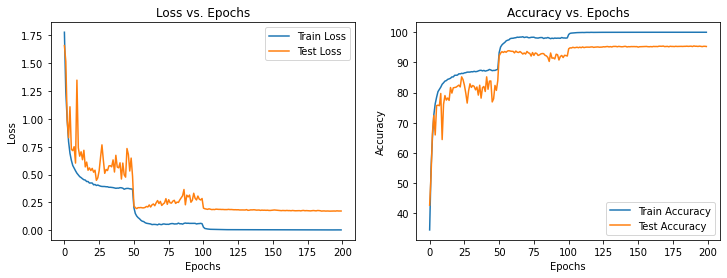

In [ ]:
# Visualize training, validation and test loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")

plt.show()

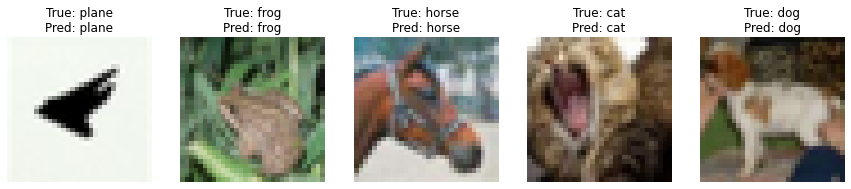

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')


best_model = simplified_resnet().to(device)
best_model.load_state_dict(torch.load('best_model.pt'))
best_model.eval()

samples = 5
dataiter = iter(testloader)
images, labels = next(dataiter)
indices = random.sample(range(0, len(images)), samples)

outputs = best_model(images.to(device))
predicted = torch.max(outputs, 1)[1]

fig = plt.figure(figsize=(15, 5))
for i, index in enumerate(indices):
    plt.subplot(1, samples, i + 1)
    imshow(images[index])
    plt.title(f"True: {classes[labels[index]]}\nPred: {classes[predicted[index]]}")

plt.show()

In [ ]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        predicted = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))

Test Accuracy: 95.46%


In [ ]:
print(f"Trainable parameters: {count_parameters(best_model)}")

Trainable parameters: 4697162


### Pruning:
Attempt at Pruning which didn't work well.

In [ ]:
  # #Second attempt at pruning
# import torch.nn.utils.prune as prune

# def prune_model(model, prune_percent):
#     for module in model.modules():
#         if isinstance(module, torch.nn.Conv2d):
#             # prune weights
#             weight = module.weight
#             if weight.dim() == 1:
#                 if weight.shape[0] == module.in_channels:
#                     weight = weight.unsqueeze(-1).unsqueeze(-1)
#                 else:
#                     weight = weight.unsqueeze(-1)
#             prune.ln_structured(module, name='weight', amount=prune_percent, n=2, dim=0)
            
#             # prune biases
#             bias = module.bias
#             if bias is not None and bias.dim() == 1:
#                 bias = bias.unsqueeze(-1)
#                 prune.ln_structured(module, name='bias', amount=prune_percent, n=1, dim=0)

#         elif isinstance(module, torch.nn.BatchNorm2d):
#             weight = module.weight
#             if weight.dim() == 1:
#                 weight = weight.unsqueeze(-1)
#             prune.ln_structured(module, name='weight', amount=prune_percent, n=1, dim=0)

#     # Remove channels with all zero weights
#     for module in model.modules():
#         if isinstance(module, torch.nn.Conv2d) and hasattr(module, 'weight_orig'):
#             module.weight.data *= module.weight_mask

#     # Remove the weight masks from the model
#     for module in model.modules():
#         if isinstance(module, torch.nn.Conv2d) and hasattr(module, 'weight_mask'):
#             del module.weight_mask
#         elif isinstance(module, torch.nn.BatchNorm2d) and hasattr(module, 'weight_mask'):
#             del module.weight_mask

# # Prune the model
# model_copy = deepcopy(best_model)
# # prune_channels(model_copy, 0.5547)
# prune_model(model_copy, 0.55)
# print(f"Trainable parameters after pruning : {count_parameters(model_copy)}")

# def prune_channels(model, prune_ratio):
#     """
#     Prune a certain percentage of channels with smallest L2-norm values in each convolutional layer of the model.

#     Args:
#         model (nn.Module): The ResNet18 model to be pruned.
#         prune_ratio (float): The percentage of channels to be pruned in each layer.
#     """
#     pruned_model = deepcopy(model)

#     # Loop through all the model's Conv2d layers
#     for layer in pruned_model.modules():
#         if isinstance(layer, nn.Conv2d):

#             # Determine the number of channels to prune
#             num_channels = layer.weight.shape[0]
#             num_prune = int(num_channels * prune_ratio)

#             # Compute L2-norm for each channel and sort the indices
#             norms = torch.sqrt(torch.sum(layer.weight**2, axis=(1,2,3)))
#             sorted_indices = torch.argsort(norms)

#             # Remove the smallest channels and update the layer's weight
#             remaining_indices = sorted_indices[num_prune:]
#             layer.weight = nn.Parameter(layer.weight[remaining_indices])

#             # Update the bias parameter if it exists
#             if layer.bias is not None:
#                 layer.bias = nn.Parameter(layer.bias[remaining_indices])

#             # Update the number of input channels for the next layer
#             layer.in_channels = layer.weight.shape[0]

#             # Update the num_features parameter in any BatchNorm2d layers that are pruned
#             for attr in ['bn1', 'bn2']:
#                 bn_layer = getattr(layer, attr, None)
#                 if bn_layer is not None:
#                     bn_layer.num_features = layer.weight.shape[0]

#         # Handle batch normalization layers separately
#         elif isinstance(layer, nn.BatchNorm2d):

#             # Determine the number of channels to prune
#             num_channels = layer.weight.shape[0]
#             num_prune = int(num_channels * prune_ratio)

#             # Sort the indices by the absolute value of the weight
#             sorted_indices = torch.argsort(layer.weight.abs())

#             # Remove the smallest channels and update the layer's weight, bias, running_mean, and running_var
#             remaining_indices = sorted_indices[num_prune:]
#             layer.weight = nn.Parameter(layer.weight[remaining_indices])
#             layer.bias = nn.Parameter(layer.bias[remaining_indices])
#             layer.running_mean = layer.running_mean[remaining_indices]
#             layer.running_var = layer.running_var[remaining_indices]

#     return pruned_model